<a href="https://colab.research.google.com/github/aashrithresearch/WoundAI/blob/main/alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from fastai.vision.all import *
from fastai.callback.fp16 import *
import torch
import os
import shutil

In [ ]:
from google.colab import files
files.upload()

In [4]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download 'ibrahimfateen/wound-classification'

Dataset URL: https://www.kaggle.com/datasets/ibrahimfateen/wound-classification
License(s): unknown
 97% 87.0M/89.8M [00:00<00:00, 121MB/s]
100% 89.8M/89.8M [00:00<00:00, 118MB/s]


In [ ]:
! unzip /content/wound-classification.zip -d /content

In [7]:
fnames = '/content/Wound_dataset copy'

In [8]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms = Resize(224),
                   batch_tfms = aug_transforms(mult=2))
dls = dblock.dataloaders(fnames, bs=32)

In [9]:
train_ds = dls.train_ds
dls = dblock.dataloaders(fnames)
from collections import Counter
class_counts = Counter([train_ds.items[i].parent.name for i in range(len(train_ds))])

print("Number of samples per class in the training set:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Number of samples per class in the training set:
Pressure Wounds: 487
Surgical Wounds: 344
Diabetic Wounds: 374
Bruises: 190
Burns: 102
Venous Wounds: 387
Normal: 165
Laseration: 102
Abrasions: 128
Cut: 73


In [10]:
valid_ds = dls.valid_ds
valid_class_counts = Counter([valid_ds.items[i].parent.name for i in range(len(valid_ds))])


print("\nNumber of samples per class in the validation set:")
for cls, count in valid_class_counts.items():
    print(f"{cls}: {count}")


Number of samples per class in the validation set:
Diabetic Wounds: 88
Pressure Wounds: 115
Abrasions: 36
Venous Wounds: 107
Bruises: 52
Laseration: 20
Normal: 35
Cut: 27
Surgical Wounds: 76
Burns: 32


In [11]:
from math import ceil
batch = dls.one_batch()
batch_size = batch[0].shape[0]
ncols = 10
nrows = ceil(batch_size / ncols)

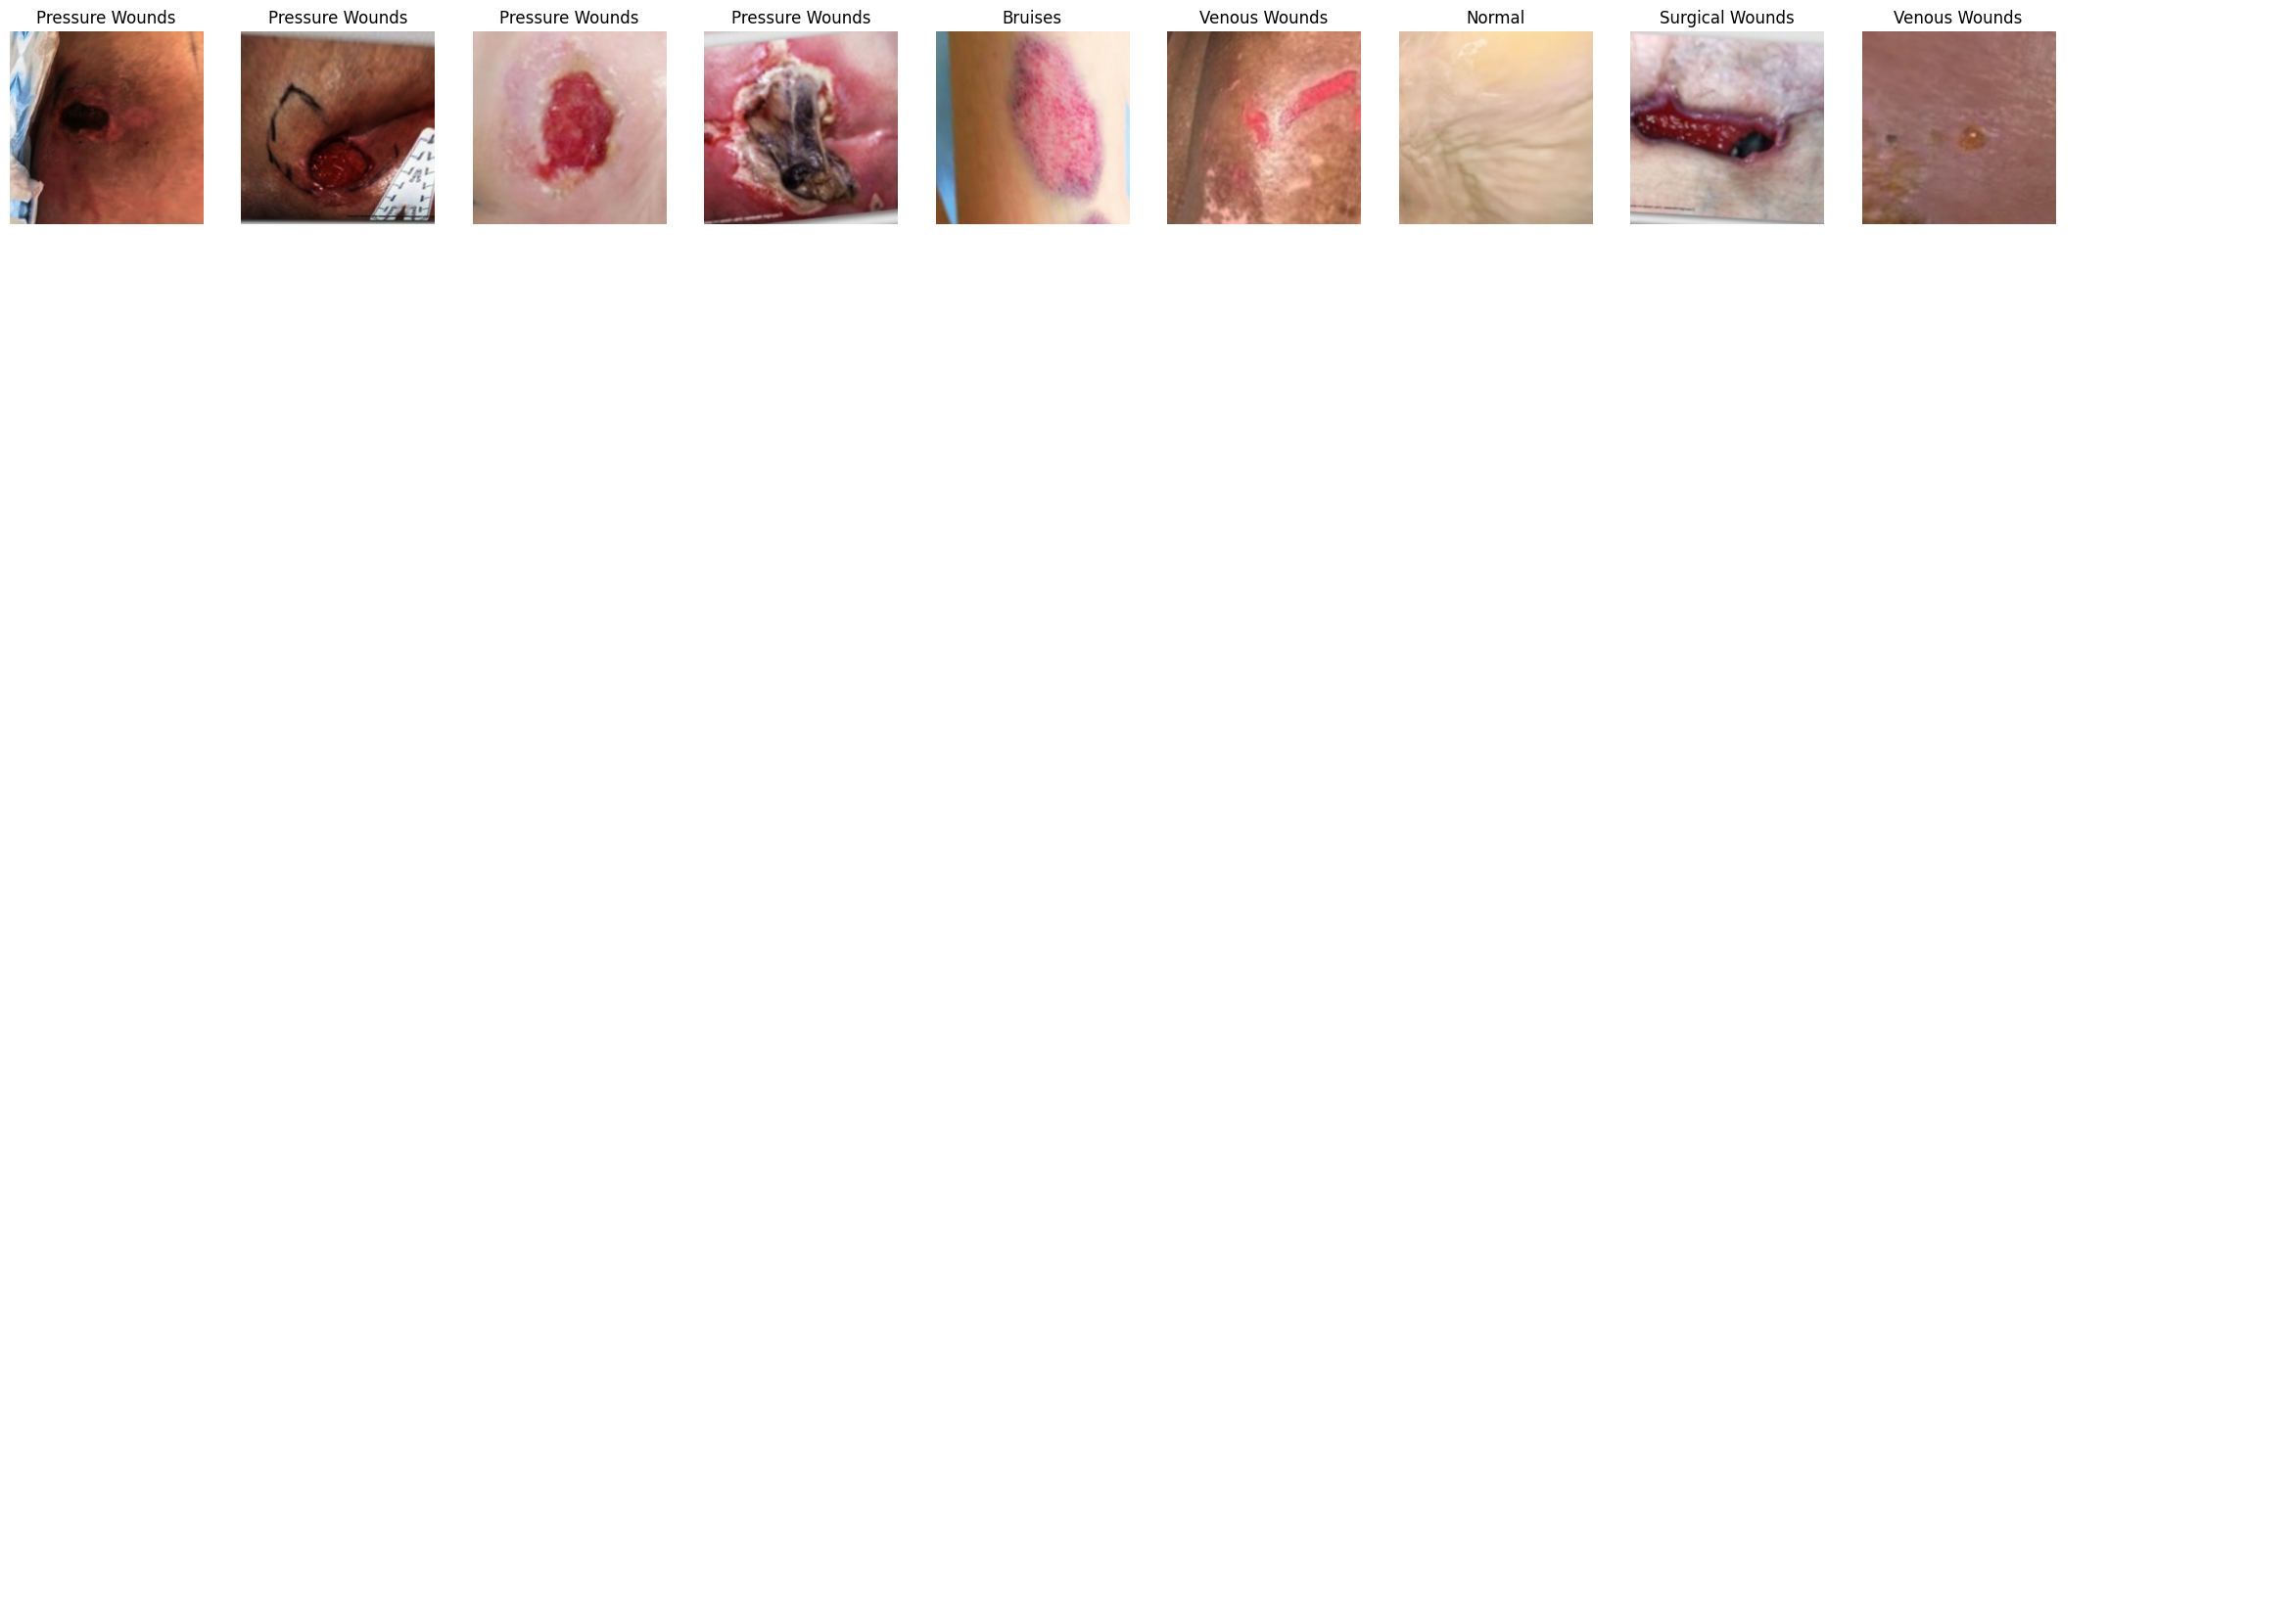

In [12]:
dls.show_batch(nrows=nrows, ncols=10)

In [13]:
metrics =  [
    accuracy,
    Precision(average='macro'),
    Recall(average='macro'),
    F1Score(average='macro'),
    RocAuc(average='macro')
]
learn_alex = vision_learner(dls, alexnet, metrics=metrics, loss_func=FocalLoss(), opt_func=Adam).to_fp16()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 116MB/s]


SuggestedLRs(valley=0.001737800776027143)

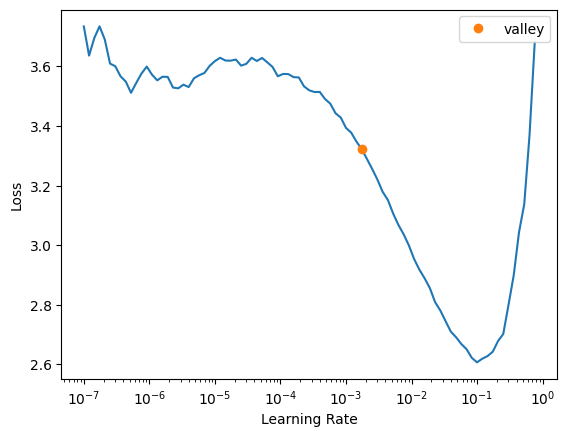

In [14]:
learn_alex.lr_find()

In [15]:
learn_alex.fit_one_cycle(15, lr_max=1e-3, cbs=[SaveModelCallback(fname='alexnet')])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,3.257428,1.846092,0.241497,0.197819,0.243360,0.199254,0.656626,00:15
1,2.556596,1.109879,0.525510,0.467554,0.482953,0.451789,0.877157,00:15
2,1.928152,0.825233,0.613946,0.623428,0.593318,0.587958,0.922719,00:14
3,1.558653,0.674972,0.673469,0.680034,0.660556,0.661049,0.943131,00:15
4,1.300435,0.599622,0.717687,0.728668,0.721466,0.718751,0.951916,00:15
5,1.117469,0.553731,0.722789,0.757266,0.713950,0.724323,0.957305,00:16
6,0.950804,0.521295,0.714286,0.746421,0.716649,0.721829,0.959429,00:16
7,0.860119,0.482436,0.731293,0.762327,0.738977,0.745870,0.962786,00:14
8,0.765889,0.457754,0.748299,0.774298,0.755018,0.759787,0.965621,00:14
9,0.710535,0.445860,0.756803,0.790059,0.765624,0.772451,0.966063,00:15


Better model found at epoch 0 with valid_loss value: 1.8460917472839355.
Better model found at epoch 1 with valid_loss value: 1.1098788976669312.
Better model found at epoch 2 with valid_loss value: 0.8252326846122742.
Better model found at epoch 3 with valid_loss value: 0.674971878528595.
Better model found at epoch 4 with valid_loss value: 0.5996217131614685.
Better model found at epoch 5 with valid_loss value: 0.553731381893158.
Better model found at epoch 6 with valid_loss value: 0.5212953686714172.
Better model found at epoch 7 with valid_loss value: 0.48243558406829834.
Better model found at epoch 8 with valid_loss value: 0.4577544331550598.
Better model found at epoch 9 with valid_loss value: 0.4458598494529724.
Better model found at epoch 10 with valid_loss value: 0.41249313950538635.
Better model found at epoch 11 with valid_loss value: 0.4060545563697815.
Better model found at epoch 12 with valid_loss value: 0.4013916850090027.
Better model found at epoch 13 with valid_loss v

In [16]:
learn_alex.unfreeze()

SuggestedLRs(valley=3.630780702224001e-05)

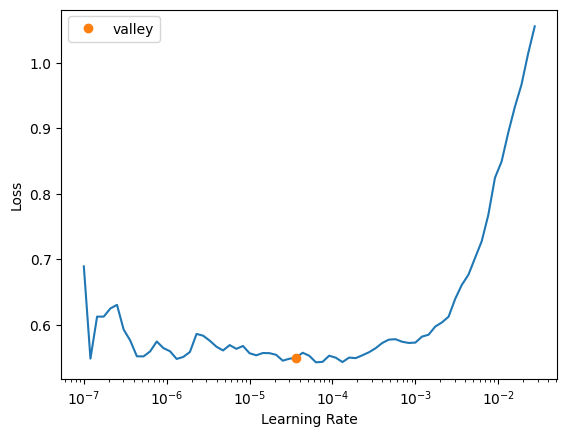

In [17]:
learn_alex.lr_find()

In [18]:
learn_alex.fit_one_cycle(20, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.572348,0.396370,0.760204,0.796131,0.771860,0.777897,0.970387,00:15
1,0.569619,0.395734,0.768707,0.807951,0.782912,0.788808,0.970952,00:15
2,0.563581,0.386050,0.765306,0.803060,0.789734,0.790137,0.971650,00:15
3,0.552787,0.382458,0.775510,0.815366,0.793193,0.798043,0.973143,00:17
4,0.527590,0.376539,0.780612,0.822128,0.805365,0.807224,0.973919,00:15
5,0.510100,0.368847,0.782313,0.816473,0.810711,0.807810,0.974526,00:14
6,0.502392,0.352452,0.787415,0.827551,0.806740,0.809807,0.976088,00:16
7,0.469869,0.331000,0.801020,0.824264,0.820726,0.817835,0.978110,00:15
8,0.456834,0.335342,0.802721,0.831223,0.825191,0.823340,0.978022,00:15
9,0.432808,0.315369,0.812925,0.843504,0.834763,0.835863,0.979278,00:15


SuggestedLRs(valley=0.00019054606673307717)

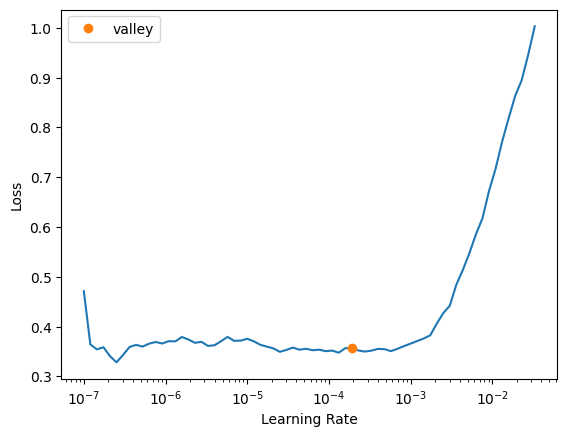

In [19]:
learn_alex.unfreeze()
learn_alex.lr_find()

In [20]:
learn_alex.fit_one_cycle(20, 1e-4)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.348294,0.291092,0.819728,0.852397,0.840912,0.843322,0.981856,00:15
1,0.349132,0.275743,0.812925,0.847450,0.839270,0.840663,0.982930,00:15
2,0.366028,0.262139,0.826531,0.853829,0.851144,0.850397,0.983712,00:15
3,0.358862,0.315569,0.809524,0.837360,0.825284,0.822224,0.982575,00:14
4,0.366981,0.283566,0.823129,0.842843,0.849032,0.843137,0.983625,00:15
5,0.361192,0.289142,0.831633,0.850685,0.856548,0.849723,0.984688,00:17
6,0.349974,0.271313,0.845238,0.872471,0.871322,0.868792,0.985711,00:15
7,0.318463,0.253090,0.843537,0.851751,0.867031,0.855426,0.986295,00:15
8,0.297795,0.228373,0.862245,0.884315,0.883280,0.881691,0.988213,00:15
9,0.283517,0.225156,0.869048,0.889011,0.891550,0.887532,0.988892,00:15


SuggestedLRs(valley=6.30957365501672e-05)

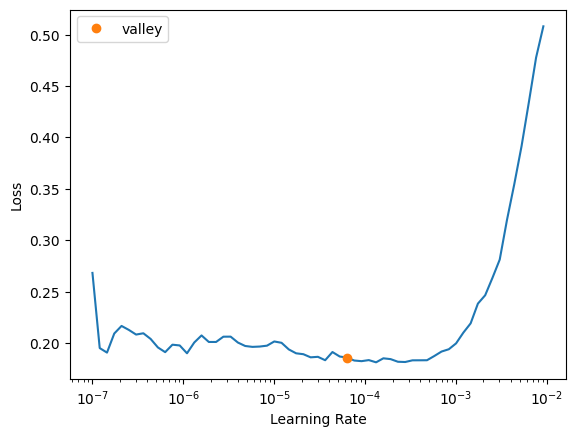

In [21]:
learn_alex.unfreeze()
learn_alex.lr_find()

In [22]:
learn_alex.fit_one_cycle(20, 1e-5)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.187648,0.169449,0.887755,0.900107,0.905518,0.900766,0.992661,00:15
1,0.189647,0.166357,0.887755,0.901334,0.905720,0.901626,0.992714,00:15
2,0.194036,0.170391,0.891156,0.904802,0.907703,0.904285,0.992585,00:15
3,0.195285,0.169325,0.889456,0.902244,0.907303,0.902771,0.992665,00:15
4,0.194350,0.165779,0.892857,0.908183,0.909042,0.906717,0.992905,00:16
5,0.189926,0.160960,0.889456,0.903478,0.908715,0.904200,0.993179,00:15
6,0.191376,0.163002,0.887755,0.903963,0.905388,0.902461,0.993194,00:15
7,0.187849,0.161841,0.886054,0.902374,0.904785,0.901455,0.993288,00:15
8,0.184161,0.161061,0.892857,0.906090,0.910988,0.906639,0.993177,00:15
9,0.194455,0.165676,0.891156,0.905626,0.907840,0.904720,0.993127,00:15
